In [11]:
# Importing useful libraries

from os.path import join

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd

from sklearn import metrics
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils import shuffle

from sklearn.feature_selection import RFE
from sklearn.model_selection import LeaveOneOut


from neurocombat_sklearn import CombatModel

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from tools import *

# Defining local variables
data_path = 'C:/Users/b_charmettant/data/parotide_ml/'

In [12]:
df_meta = get_meta_data(data_path)

ls_exams, id_to_feat, feat_to_id = load_features(df_meta, data_path, verbose=False, type_to_include=['t1', 't2', 'gado', 'diff'])


features = []
labels = []

# Meta data fields to include in meta variables for harmonization

meta_fields = ['sexe', 'tesla', 'age']
meta_variables = []

for exam in ls_exams:
    lbl, ft, meta = format_exam(exam, feat_to_id, meta_fields=meta_fields)
    features.append(ft)
    labels.append(lbl)
    meta_variables.append(meta)
    
features = np.array(features)
labels = np.array(labels)
meta_variables = np.array(meta_variables)

print(f"{len(labels)} with {len(features[0])} features")
print(f"Labels : {len(labels) - sum(labels)} benign lesions and {sum(labels)} malignant")

# Adjusting the scales of the different features

scaler = StandardScaler()
rescaled_features = scaler.fit_transform(features)

print(f"Shape features : {rescaled_features.shape}")
print(f"Shape meta variables : {meta_variables.shape}")

n_features = features.shape[1]
n_exams = features.shape[0]

features = rescaled_features

107 with 432 features
Labels : 58 benign lesions and 49 malignant
Shape features : (107, 432)
Shape meta variables : (107, 3)


In [13]:
### To test feature extraction on a subset of values
print("Extracting a subset of values")
features, labels, meta_variables = shuffle(features, labels, meta_variables, random_state=43)

split_id = 90

train_features = features[:split_id]
train_labels = labels[:split_id]
train_meta = meta_variables[:split_id]

test_features = features[split_id:]
test_labels = labels[split_id:]
test_meta = meta_variables[split_id: ]

print(f"Shape features (train): {train_features.shape}")
print(f"Shape features (test): {test_features.shape}")

Extracting a subset of values
Shape features (train): (90, 432)
Shape features (test): (17, 432)


In [14]:
# Feature harmonization using ComBat

harmonization = CombatModel()

train_features = harmonization.fit_transform(train_features,
                                     train_meta[:, 1].reshape(-1,1),
                                     train_meta[:, 0].reshape(-1,1),
                                     train_meta[:, 2].reshape(-1,1))

if len(test_features) > 0:
    test_features = harmonization.transform(test_features,
                                    test_meta[:, 1].reshape(-1,1),
                                    test_meta[:, 0].reshape(-1,1),
                                    test_meta[:, 2].reshape(-1,1))

In [15]:
# Statistical analysis of the different features

feature_significance_p = feature_t_test(train_features, train_labels, id_to_feat)
feature_significance_auc = feature_auc(train_features, train_labels, id_to_feat, LogisticRegression(penalty='none'))

In [16]:
# Selection of significant features

n_new_features = 5
# Based on statistical values

selection_p_value = choose_features_from_dict(feature_significance_p, n_new_features, feat_to_id)

# Based on RFE algorithm

estimator = LogisticRegression(penalty='l1', solver='liblinear', C=1)
selector = RFE(estimator, 15, step=1).fit(train_features, train_labels)
selection_rfe = np.where(selector.support_.astype(int) > 0)[0]

# We choose to use rfe

selected_features_id = selection_rfe

In [17]:
print("<--------->  {:^49}  <---------> ".format('Features selected'))
for i, id_feature in enumerate(selected_features_id):
    feature_name = id_to_feat[id_feature]

    print("({:2}) {:40.40} - Auc: {:.3f} - p-value: {:.3f}".format(i, 
                                                                   feature_name, feature_significance_auc[feature_name], 
                                                                   feature_significance_p[feature_name]))

<--------->                  Features selected                  <---------> 
( 0) t1_OriginalShapeVolume                   - Auc: 0.597 - p-value: 0.046
( 1) t1_OriginalShapeCompactness2             - Auc: 0.628 - p-value: 0.012
( 2) t1_OriginalGrayLevelCo-occurrenceMatrixC - Auc: 0.497 - p-value: 0.570
( 3) t1_OriginalGrayLevelSizeZoneMatrixGrayLe - Auc: 0.521 - p-value: 0.518
( 4) t1_OriginalNeighboringGrayToneDifference - Auc: 0.557 - p-value: 0.136
( 5) t2_OriginalFirstOrderMinimum             - Auc: 0.535 - p-value: 0.941
( 6) t2_OriginalGrayLevelCo-occurrenceMatrixC - Auc: 0.623 - p-value: 0.013
( 7) gado_OriginalGrayLevelCo-occurrenceMatri - Auc: 0.554 - p-value: 0.252
( 8) gado_OriginalGrayLevelDependenceMatrixLa - Auc: 0.568 - p-value: 0.092
( 9) diff_OriginalShapeElongation             - Auc: 0.595 - p-value: 0.096
(10) diff_OriginalShapeFlatness               - Auc: 0.568 - p-value: 0.460
(11) diff_OriginalGrayLevelCo-occurrenceMatri - Auc: 0.535 - p-value: 0.651
(12) diff_O

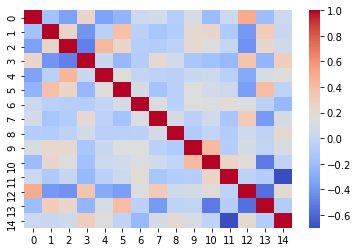

In [18]:
df_features = pd.DataFrame(features[:, selected_features_id])
cor = df_features.corr()
    
sns.heatmap(cor, cmap='coolwarm')
plt.show()

In [19]:
train_features_s = train_features[:, selected_features_id]
test_features_s = test_features[:, selected_features_id]

print(f"Shape features (train): {train_features_s.shape}")
print(f"Shape features (test): {test_features_s.shape}")

Shape features (train): (90, 15)
Shape features (test): (17, 15)


In [20]:
# Final model classification

# clf = RandomForestClassifier(n_estimators=100, verbose=0)
# clf = SVC(C=1, probability=True, kernel='poly')
clf = LogisticRegression(penalty='l1', solver='liblinear', C=1)
# clf = DecisionTreeClassifier()


# Prediction using leave one out

loo = LeaveOneOut()

loo_predictions = []
loo_labels = []

X = train_features_s
y = train_labels

for train_index, test_index in loo.split(train_features_s):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf.fit(X_train, y_train)
    
    pred = clf.predict_proba(X_test)[0, 1]

    
    loo_predictions.append(pred)
    loo_labels.append(y_test)

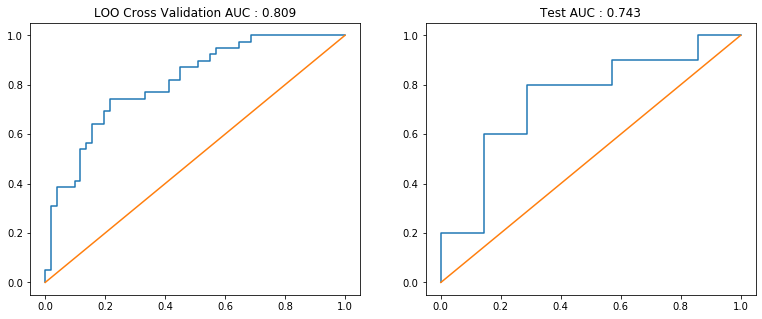

In [21]:
plt.rcParams['figure.figsize'] = (13, 5)

# Calculating AUC
fpr, tpr, _ = metrics.roc_curve(loo_labels,  loo_predictions)
auc = metrics.roc_auc_score(loo_labels, loo_predictions)

plt.subplot(1,2,1)
plt.title("LOO Cross Validation AUC : {:.3f}".format(auc))
plt.plot(fpr,tpr)
plt.plot(fpr, fpr)

if len(test_features_s) >= 10:
    
    test_predictions = np.zeros(len(test_features_s))
    
    for i in range(len(test_features_s)):
        
        X = train_features_s
        y = train_labels
        
        ids_to_add = list(range(len(test_features_s)))
        
        ids_to_add.remove(i)
        
        X = np.append(X, test_features_s[ids_to_add], axis=0)
        
        y = np.append(y, test_labels[ids_to_add])
        
        clf.fit(X, y)
        
        test_predictions[i] = clf.predict_proba(test_features_s)[i, 1]
    
    # Calculating AUC
    fpr, tpr, _ = metrics.roc_curve(test_labels,  test_predictions)
    auc = metrics.roc_auc_score(test_labels,  test_predictions)

    plt.subplot(1,2,2)
    plt.title("Test AUC : {:.3f}".format(auc))
    plt.plot(fpr,tpr)
    plt.plot(fpr, fpr)

In [22]:
print(clf.coef_)
# print(clf.classes_)

# print(clf.score(X_train, y_train))
# print(clf.score(X_test, y_test))

[[ 1.03226292 -1.45619015  0.70816724  0.64515621 -0.76616163  0.47315144
   0.27911732  0.29424722  0.4970604   0.14224964  0.98643193 -0.6585338
  -0.55295225  0.54996167 -0.89371845]]
